In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import mean
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col, explode, array, lit, isnan, when, count
from pyspark.mllib.util import MLUtils
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
def load_dataset():
    # Load training data
    # File location and type
    file_location_train = "/FileStore/tables/train.csv"
    file_location_test = "/FileStore/tables/test.csv"
    file_type = "csv"

    # CSV options
    infer_schema = "true"
    first_row_is_header = "true"
    delimiter = ","

    # The applied options are for CSV files. For other file types, these will be ignored.
    train = spark.read.format(file_type) \
      .option("inferSchema", infer_schema) \
      .option("header", first_row_is_header) \
      .option("sep", delimiter) \
      .load(file_location_train)

    test = spark.read.format(file_type) \
      .option("inferSchema", infer_schema) \
      .option("header", first_row_is_header) \
      .option("sep", delimiter) \
      .load(file_location_test)
    
    print("-----NA VALUES IN TRAIN------")
    for c in train.columns:
        print("NA values in column {}: {}".format(c, train.filter(col(c).isNull()).count()))
        
    print("\n-----NA VALUES IN TEST-------")
    for c in test.columns:
        print("NA values in column {}: {}".format(c, test.filter(col(c).isNull()).count()))
    
    #FILL NA FOR SMOKING
    train = train.na.fill('No Info', subset=['smoking_status'])
    test = test.na.fill('No Info', subset=['smoking_status'])
    
    #FILL NA FOR BMI
    bmi_median_train = train.approxQuantile("bmi", [0.5], 0)[0]
    bmi_median_test  = test.approxQuantile("bmi", [0.5], 0)[0]
    train = train.na.fill(bmi_median_train, subset=['bmi'])
    test  = test.na.fill(bmi_median_test, subset=['bmi'])

    return train, test

train, test = load_dataset()

-----NA VALUES IN TRAIN------
NA values in column id: 0
NA values in column gender: 0
NA values in column age: 0
NA values in column hypertension: 0
NA values in column heart_disease: 0
NA values in column ever_married: 0
NA values in column work_type: 0
NA values in column Residence_type: 0
NA values in column avg_glucose_level: 0
NA values in column bmi: 1462
NA values in column smoking_status: 13292
NA values in column stroke: 0

-----NA VALUES IN TEST-------
NA values in column id: 0
NA values in column gender: 0
NA values in column age: 0
NA values in column hypertension: 0
NA values in column heart_disease: 0
NA values in column ever_married: 0
NA values in column work_type: 0
NA values in column Residence_type: 0
NA values in column avg_glucose_level: 0
NA values in column bmi: 591
NA values in column smoking_status: 5751


In [ ]:
train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = false)
 |-- smoking_status: string (nullable = false)
 |-- stroke: integer (nullable = true)



In [ ]:
train.groupBy('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  783|
|     0|42617|
+------+-----+



In [ ]:
major_df = train.filter(col("stroke") == 0)
minor_df = train.filter(col("stroke") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

a = range(ratio)
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
oversampled_df = major_df.unionAll(oversampled_df)
print("-------OVER-----------")
oversampled_df.groupBy('stroke').count().show()

print("\n\n-------UNDER----------")
sampled_majority_df = major_df.sample(False, 1/ratio)
undersampled_df = sampled_majority_df.unionAll(minor_df)
undersampled_df.groupBy('stroke').count().show()

ratio: 54
-------OVER-----------
+------+-----+
|stroke|count|
+------+-----+
|     0|42617|
|     1|42282|
+------+-----+



-------UNDER----------
+------+-----+
|stroke|count|
+------+-----+
|     0|  763|
|     1|  783|
+------+-----+



In [ ]:
def prepare_dataset(train_df, test_df):
    
    def encode_sting(category_df):
        CAT_COLUMNS = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
        FEATURE_COLUMNS = ['gender',  'age',  'hypertension',  'heart_disease',  'ever_married',  'work_type',  'Residence_type',  'avg_glucose_level',  'bmi',  'smoking_status']
        
        if "features" in category_df.columns:
                return category_df

        for cat_column in CAT_COLUMNS:
            varIdxer = StringIndexer(inputCol=cat_column,outputCol=f"{cat_column}_index").fit(category_df)
            category_df = varIdxer.transform(category_df)
            encoder = OneHotEncoder(inputCol=f"{cat_column}_index", outputCol=f"{cat_column}_cat")
            ohe = encoder.fit(category_df)
            category_df = ohe.transform(category_df)

        processed_named_feature_columns = [f"{x}_cat" if x in CAT_COLUMNS else x for x in FEATURE_COLUMNS]
        assembler = VectorAssembler(inputCols=processed_named_feature_columns,outputCol="features")

        return assembler.transform(category_df)
    
    
    FEATURE_COLUMNS = ['gender',  'age',  'hypertension',  'heart_disease',  'ever_married',  'work_type',  'Residence_type',  'avg_glucose_level',  'bmi',  'smoking_status']
    
    train, val = train_df.randomSplit([0.7, 0.3], seed = 2018)
    print("Training Dataset Count: " + str(train.count()))
    print("Validation Dataset Count: " + str(val.count()))
    
    train = encode_sting(train)
    test  = encode_sting(test_df)
    val   = encode_sting(val)
    
    return train, val, test

In [ ]:
def validate_model(model, val):
    STRING_SEPARATOR = "\n\n---------{}----------"
    predictionAndTarget = model.transform(val)

    evaluatorMulti = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction")
    evaluator = BinaryClassificationEvaluator(labelCol="stroke")

    # Get metrics
    acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
    f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
    weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
    weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
    auc = evaluator.evaluate(predictionAndTarget)

    print(STRING_SEPARATOR.format("Summary Stats"))
    print("Accuracy = %s" % acc)
    print("AUC = %s" % auc)
    print("F1 Score = %s" % f1)
    print("Weighted Precision = %s" % weightedPrecision)
    print("Recall = %s" % weightedRecall)

def validate_linear_regression(mlrModel):
    STRING_SEPARATOR = "\n\n---------{}----------"
    print(STRING_SEPARATOR.format("REGRESSION_MODEL_DETAILS"))
    print("Coefficients: %s" % str(mlrModel.coefficients))
    print("Intercept: %s" % str(mlrModel.intercept))
    
    trainingSummary = mlrModel.summary
    print("numIterations: %d" % trainingSummary.totalIterations)
    print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
    print(STRING_SEPARATOR.format("ROC"))

    # Set the model threshold to maximize F-Measure
    fMeasure = trainingSummary.fMeasureByThreshold
    maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
    bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
        .select('threshold').head()['threshold']
    mlrModel.setThreshold(bestThreshold)
    
    #GIVE PLOT
    roc = trainingSummary.roc.toPandas()
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

def create_model(train, val, test):
    STRING_SEPARATOR = "\n\n\n------------------------{}------------------------"
    
    print(STRING_SEPARATOR.format("DecisionTreeClassifier"))
    dtc = DecisionTreeClassifier(labelCol='stroke',featuresCol='features')
    dtcModel = dtc.fit(train) 
    validate_model(dtcModel, val)
    
    print(STRING_SEPARATOR.format("LogisticRegression"))
    mlr = LogisticRegression(maxIter=10, featuresCol='features', labelCol ='stroke')
    mlrModel = mlr.fit(train)
    validate_model(mlrModel, val)
    validate_linear_regression(mlrModel)
    return dtcModel.transform(test), mlrModel.transform(test)


Training Dataset Count: 30424
Validation Dataset Count: 12976



------------------------DecisionTreeClassifier------------------------


---------Summary Stats----------
Accuracy = 0.9831997533908755
AUC = 0.27735779254742365
F1 Score = 0.9751000274361515
Weighted Precision = 0.9671326642273153
Recall = 0.9831997533908755



------------------------LogisticRegression------------------------


---------Summary Stats----------
Accuracy = 0.9834309494451294
AUC = 0.850081917470199
F1 Score = 0.9752156308714534
Weighted Precision = 0.9671364323265488
Recall = 0.9834309494451294


---------REGRESSION_MODEL_DETAILS----------
Coefficients: [-1.5305672893956968,-1.447933178262342,0.06801665139465415,0.24043459277565213,0.6330225119855369,-0.5765349310736528,-0.8467718203045784,-1.0260911614675052,-1.9066002379021885,-1.1746752392841984,0.020509033117726106,0.00425939936623222,-0.022014227583025132,-0.22857902317592263,-0.21791674352731577,-0.2111964136086334]
Intercept: -4.68530315393204
numI

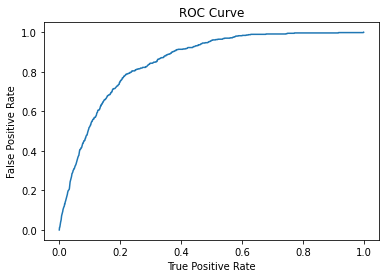

Training set areaUnderROC: 0.8511713030056134


In [ ]:
#FULL DATA
train, val, test = prepare_dataset(train, test)
predictions_test_tree, predictions_test_reg = create_model(train, val, test)
# predictions_test_tree.select('id','probability', 'prediction').show(5)

Training Dataset Count: 1101
Validation Dataset Count: 445



------------------------DecisionTreeClassifier------------------------


---------Summary Stats----------
Accuracy = 0.5056179775280899
AUC = 0.4267183901078919
F1 Score = 0.38083011249504595
Weighted Precision = 0.5686726215055166
Recall = 0.5056179775280899



------------------------LogisticRegression------------------------


---------Summary Stats----------
Accuracy = 0.5303370786516854
AUC = 0.8671152058835419
F1 Score = 0.39026571052909553
Weighted Precision = 0.755991217874209
Recall = 0.5303370786516854


---------REGRESSION_MODEL_DETAILS----------
Coefficients: [-0.1676247963561127,0.0785152002156805,0.4749938460771834,0.5891694115283458,-0.2159515347091534,-3.029200388071489,-3.0894783881131502,-2.993174099709466,-2.9333469566937405,-0.29536327773580273,0.004720940782246425,0.013154648440548844,-0.41360417227103213,-0.07742789506518424,-0.2842326994404686]
Intercept: -1.85515197389732
numIterations: 10
objectiveHi

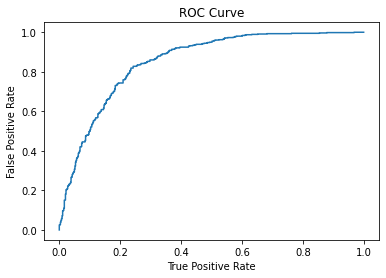

Training set areaUnderROC: 0.852340532263174
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------------+-------------+------------------+----------------+---------------+-------------+--------------------+------------------+--------------------+------------------+--------------------+-------------+--------------------+----------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|gender_index|   gender_cat|ever_married_index|ever_married_cat|work_type_index|work_type_cat|Residence_type_index|Residence_type_cat|smoking_status_index|smoking_status_cat|            features|rawPrediction|         probability|prediction|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------------+-------------+------------------+----------------+---------------+-------------

In [ ]:
#UNDER DATA
under_train, under_val, test = prepare_dataset(undersampled_df, test)
predictions_test_tree, predictions_test_reg = create_model(under_train, under_val, test)
predictions_test_tree.select('id','probability', 'prediction').show(5)

Training Dataset Count: 59430
Validation Dataset Count: 25469



------------------------DecisionTreeClassifier------------------------


---------Summary Stats----------
Accuracy = 0.7822450822568613
AUC = 0.7911569898178092
F1 Score = 0.7814234643781192
Weighted Precision = 0.7865116167962989
Recall = 0.7822450822568612



------------------------LogisticRegression------------------------


---------Summary Stats----------
Accuracy = 0.7718010129961914
AUC = 0.8478637298752757
F1 Score = 0.7715285739653397
Weighted Precision = 0.7730806476570957
Recall = 0.7718010129961914


---------REGRESSION_MODEL_DETAILS----------
Coefficients: [-1.8468807716008637,-1.6391821414856442,0.07294035378141936,0.3755026737748627,0.566290599266912,-0.26693586697300564,-1.2293981483232683,-1.1308781195549287,-1.291411637421799,-2.6986137945496695,0.10420915196509441,0.0036501572993343522,-0.00951440546085051,-0.6183107970368992,-0.5113733794112155,-0.4349080409481079]
Intercept: -0.868808204964141
numIte

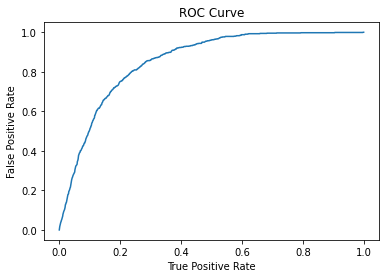

Training set areaUnderROC: 0.8537287349992155
+-----+--------------------+----------+
|   id|         probability|prediction|
+-----+--------------------+----------+
|36306|[0.15937339118923...|       1.0|
|61829|[0.14236509758897...|       1.0|
|14152|[0.98393246187363...|       0.0|
|12997|[0.98393246187363...|       0.0|
|40801|[0.66531322505800...|       0.0|
+-----+--------------------+----------+
only showing top 5 rows



In [ ]:
#OVER DATA
over_train, over_val, test = prepare_dataset(oversampled_df, test)
predictions_test_tree, predictions_test_reg = create_model(over_train, over_val, test)
predictions_test_tree.select('id','probability', 'prediction').show(5)